<a href="https://colab.research.google.com/github/Simple2006/gun_det/blob/main/gun_detv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U -r yolov5/requirements.txt  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 4060 (delta 14), reused 13 (delta 6), pack-reused 4027
Receiving objects: 100% (4060/4060), 7.27 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (2735/2735), done.
Requirement already up-to-date: Cython in /usr/local/lib/python3.6/dist-packages (from -r yolov5/requirements.txt (line 4)) (0.29.21)
     |████████████████████████████████| 11.6MB 5.8MB/s 
Requirement already up-to-date: numpy>=1.18.5 in /usr/local/lib/python3.6/dist-packages (from -r yolov5/requirements.txt (line 6)) (1.19.5)
     |████████████████████████████████| 50.4MB 87kB/s 
     |████████████████████████████████| 2.2MB 33.8MB/s 
     |████████████████████████████████| 276kB 51.8MB/s 
     |████████████████████████████████| 25.9MB 71.6MB/s 
Requirement already up-to-date: tensorboard>=2.2 in /usr/local/lib/python3.6/dist-packages (from -r yolov5/re

In [2]:
%cd /content/yolov5

/content/yolov5


In [3]:
!ls

data	    hubconf.py	README.md	  train.py	  weights
detect.py   LICENSE	requirements.txt  tutorial.ipynb
Dockerfile  models	test.py		  utils


In [4]:
import torch
from IPython.display import Image  # for displaying images
from utils.google_utils import gdrive_download  # for downloading models/datasets

print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.7.1 CPU


In [5]:
# You need to sign up in roboflow to get the key and then you can use the dataset
!curl -L "https://app.roboflow.com/ds/hOIQ9EFoh5?key=6m31bk8TQE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1278      0 --:--:-- --:--:-- --:--:--  1276
100 2522k  100 2522k    0     0  3028k      0 --:--:-- --:--:-- --:--:-- 3028k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/14973621184_8ae8634588_o_jpg.rf.a648e6a2a4f0ee941a9e338ae11ebe89.jpg  
 extracting: test/images/15408258698_cfeac3b483_o_jpg.rf.dfaf4969eb356195f1932961614a62ae.jpg  
 extracting: test/images/2003963909_2a4194454a_o_jpg.rf.5f750ff0f6099fd662683bd8fd07cb10.jpg  
 extracting: test/images/3842524451_a294edd4d9_o_jpg.rf.076d75d055869e9c1574a786bcb582a1.jpg  
 extracting: test/images/464123409_5e5371e575_o_jpg.rf.c8c52f1be11261302b6fce47306e70ed.jpg  
 extracting: test/images/5250149837_0d815aac5a_o_jpg.rf.5c3ceebe

In [6]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['cavity']

In [7]:
# define number of classes based on YAML
# data.yaml contains the information about number of classes and their labels required for this project
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
# Below we are changing the data configuration for right path to the dataset
%%writetemplate /content/yolov5/data.yaml

train: ./train/images
val: ./valid/images

nc: 1
names: ['guns']

In [10]:
%cat data.yaml


train: ./train/images
val: ./valid/images

nc: 1
names: ['guns']

In [11]:
with open(r'data.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    labels_list = yaml.load(file, Loader=yaml.FullLoader)

    label_names = labels_list['names']

In [12]:
print("Number of Classes are {}, whose labels are {} for this Object Detection project".format(num_classes,label_names))

Number of Classes are 1, whose labels are ['guns'] for this Object Detection project


In [13]:
#this is the model configuration we will use for our tutorial 
# yolov5s.yaml contains the configuration of neural network required for training.
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [14]:
# Below we are changing the configuration so that it becomes compatible to number of classes required in this project
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: 1  # number of classes  # CHANGED HERE
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [15]:
import os
os.chdir('/content/yolov5')

In [38]:
# train yolov5s on guns detection data for 100 epochs [aroung 1000 epochs for better training and result]
# NOTE: All the images are already pre-processed to 416 x 416 size.
# We will be training for 100 epoch (increase it for better result) with batch size of 80
# data.yaml also contains the information about location of Train and Validation Data. That's how you get the train data.
# the training also requires the configuration of neural network, which is in custom_yolov5s.yaml
# weights will be by-default stored at /content/yolov5/runs/exp2/weights/best.pt
# time its performance
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 80 --epochs 10 --data './data.yaml' --cfg './models/custom_yolov5s.yaml' --weights ''

/content/yolov5
YOLOv5 v4.0-10-g1d1c056 torch 1.7.1 CPU

Namespace(adam=False, batch_size=80, bucket='', cache_images=False, cfg='./models/custom_yolov5s.yaml', data='./data.yaml', device='', epochs=10, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp3', single_cls=False, sync_bn=False, total_batch_size=80, weights='/content/yolov5/runs/train/exp/weights/best.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-01-12 06:20:02.454167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, 

In [ ]:
# Start tensorboard
# Launch after you have started training to all the graphs needed for inspection
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs

GROUND TRUTH TRAINING DATA:


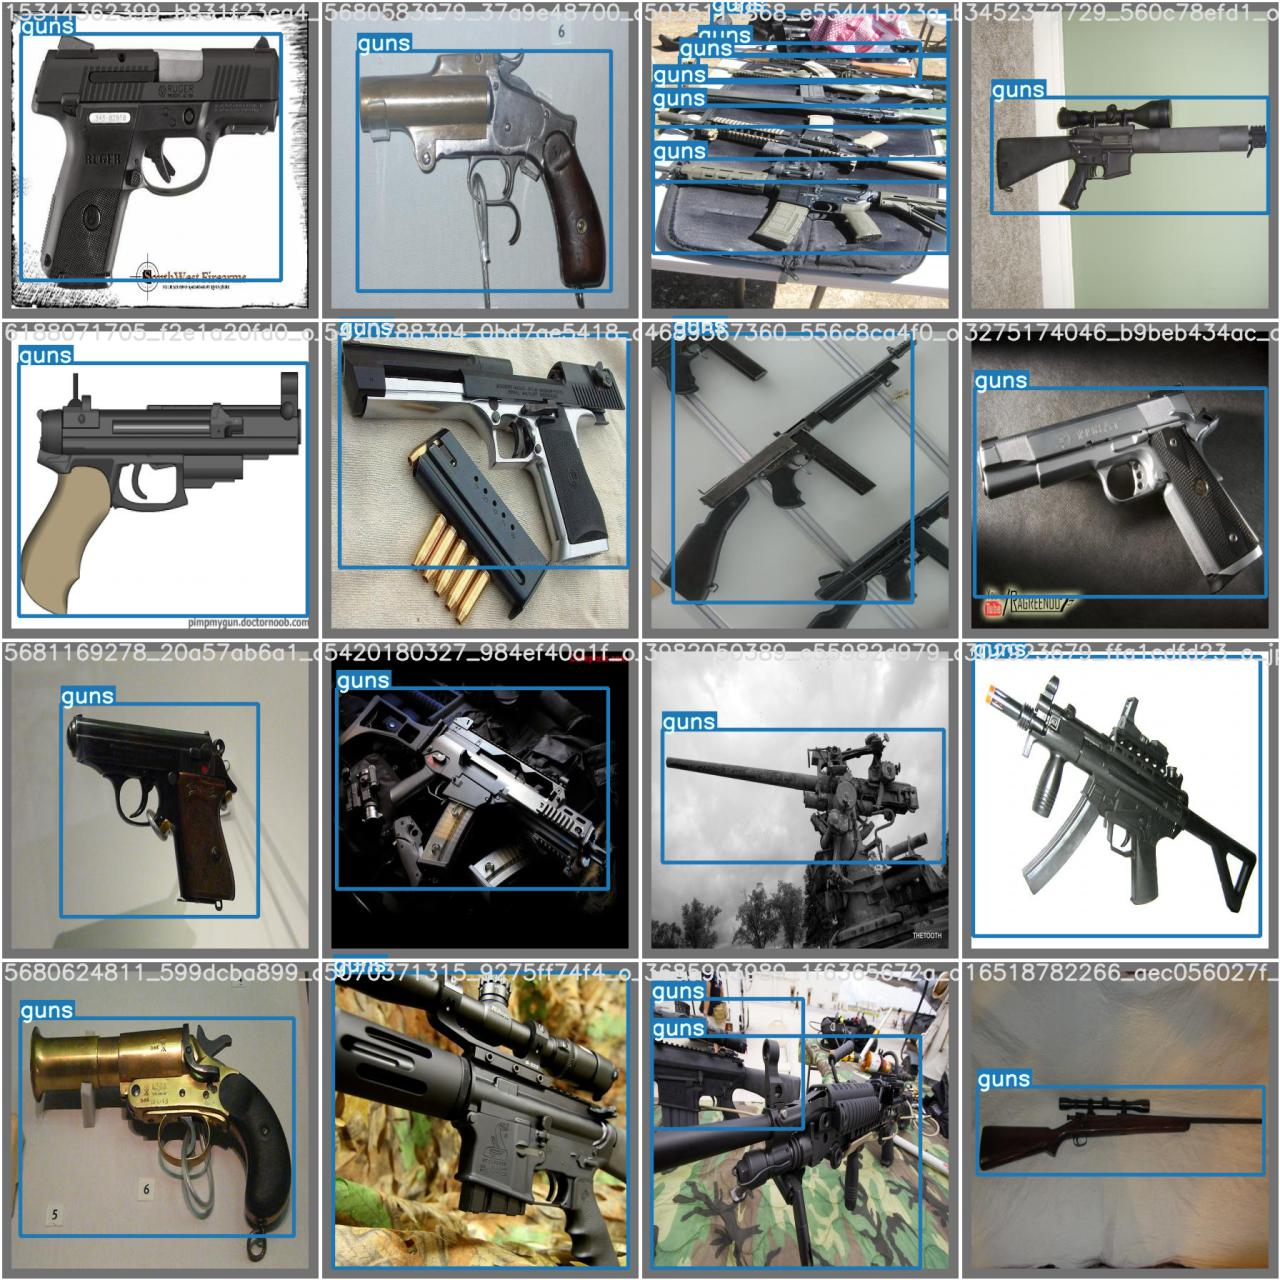

In [19]:
# first, display our ground truth data
# The ground truth [Train data] is available in jpg file at location /content/yolov5/runs/train/exp2/test_batch0_labels.jpg 
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


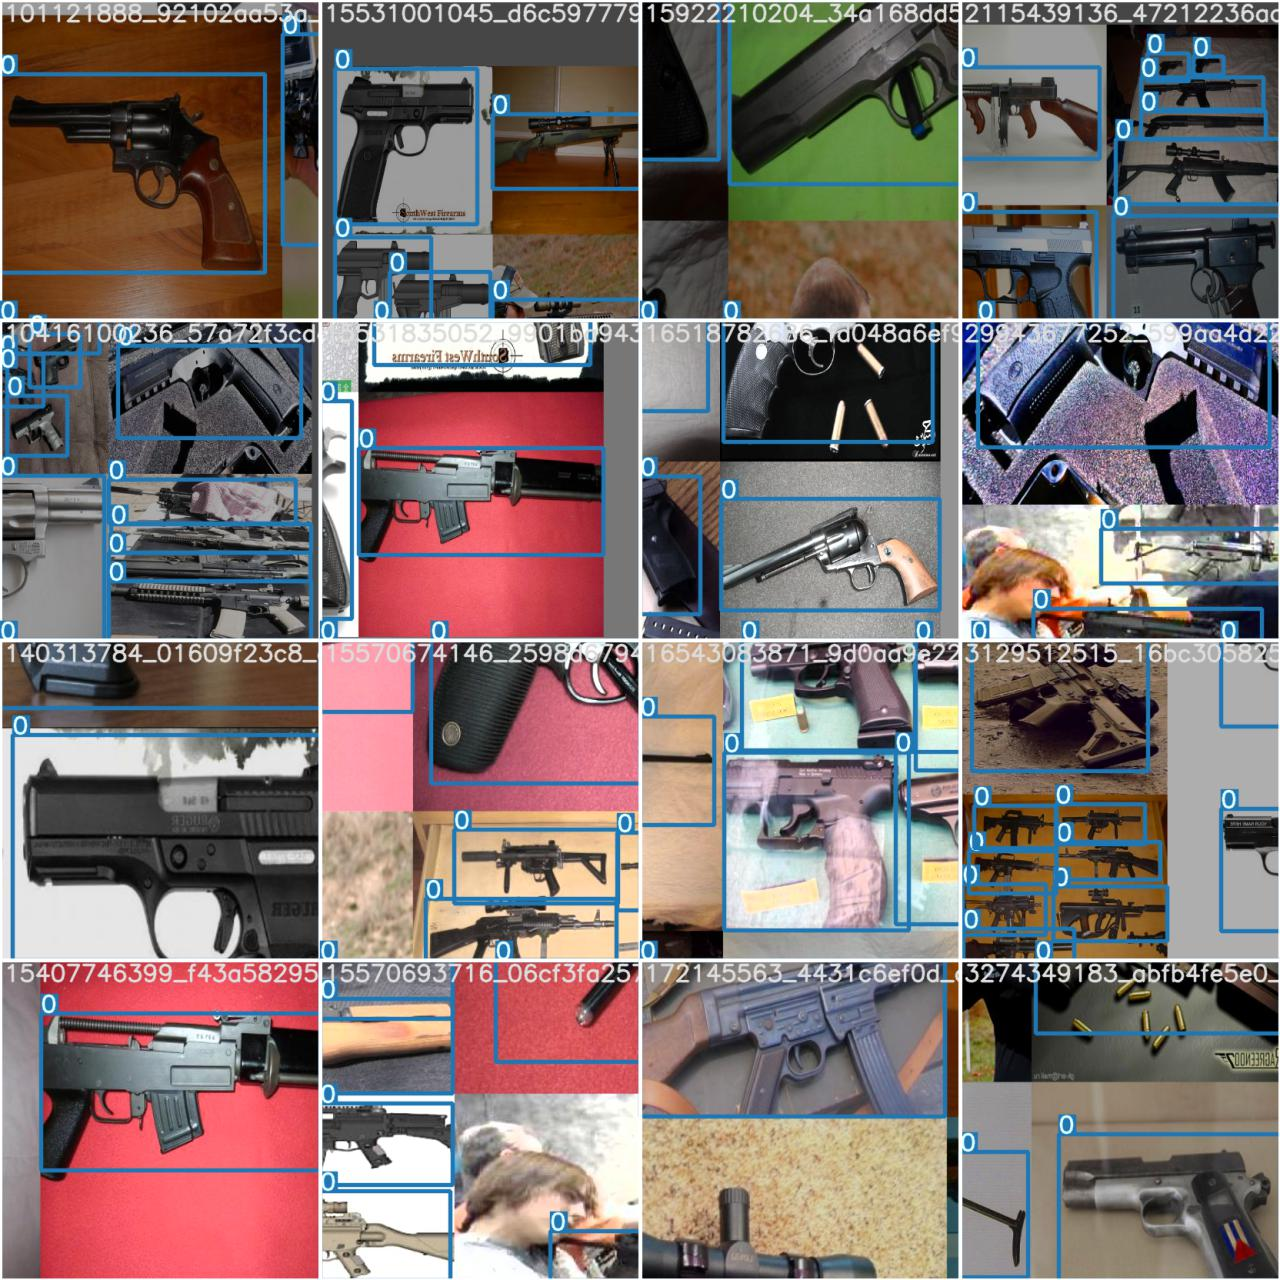

In [22]:
# print out an augmented training example
# Below is the augmented training data.
# NOTE: The dataset already contains the augmented data with annotations, so that you dont have to do it.
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/exp/train_batch0.jpg', width=900)

In [24]:
# use the best weights!
# Final weights will be by-default stored at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 416 --conf 0.4 --source ./test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='./test/images', update=False, view_img=False, weights=['/content/yolov5/runs/train/exp/weights/best.pt'])
YOLOv5 v4.0-10-g1d1c056 torch 1.7.1 CPU

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPS
image 1/10 /content/yolov5/test/images/14973621184_8ae8634588_o_jpg.rf.a648e6a2a4f0ee941a9e338ae11ebe89.jpg: 416x416 Done. (0.275s)
image 2/10 /content/yolov5/test/images/15408258698_cfeac3b483_o_jpg.rf.dfaf4969eb356195f1932961614a62ae.jpg: 416x416 Done. (0.233s)
image 3/10 /content/yolov5/test/images/2003963909_2a4194454a_o_jpg.rf.5f750ff0f6099fd662683bd8fd07cb10.jpg: 416x416 Done. (0.231s)
image 4/10 /content/yolov5/test/images/3842524451_a294edd4d9_o_jpg.rf.076d75d055869e9c1574a786bcb582a1.jpg: 416x416 Done. (0.225s)
image 5/10 /c

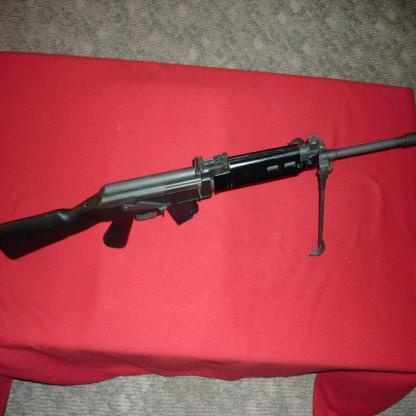

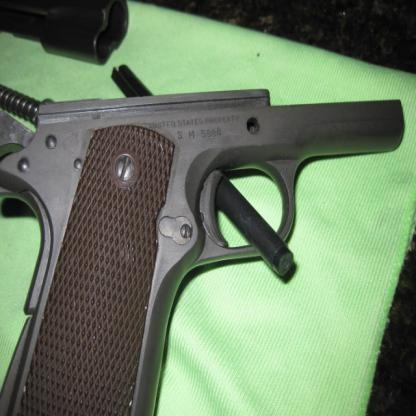

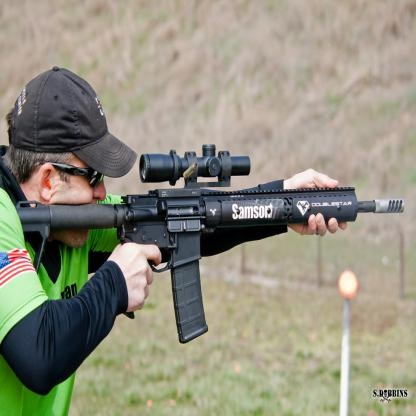

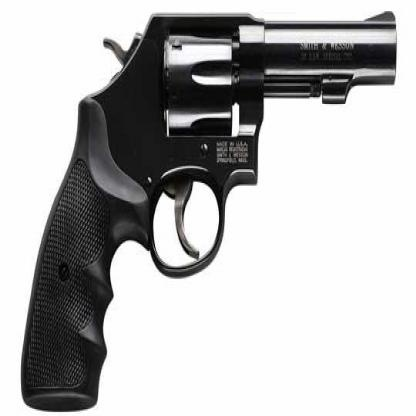

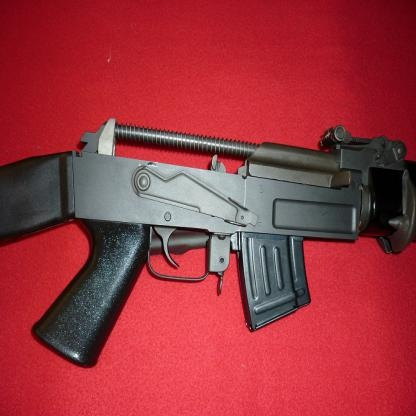

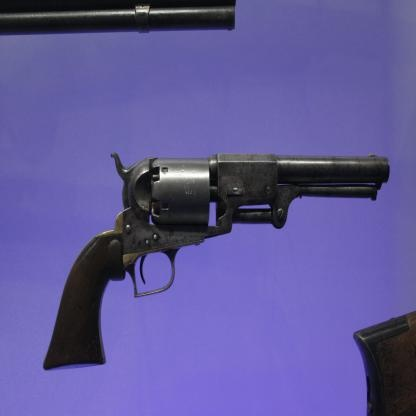

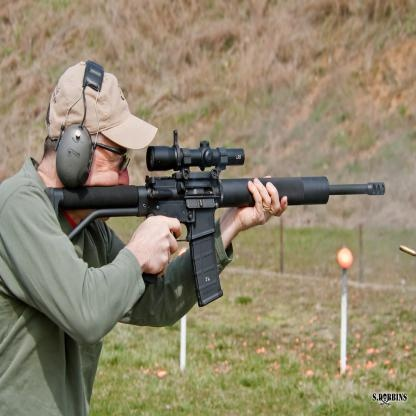

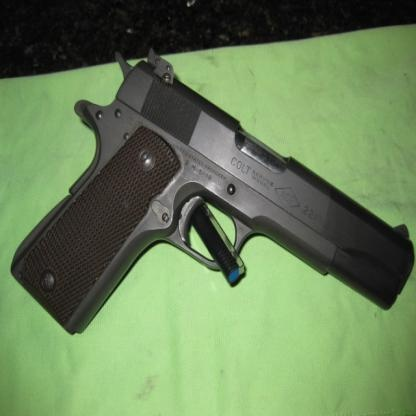

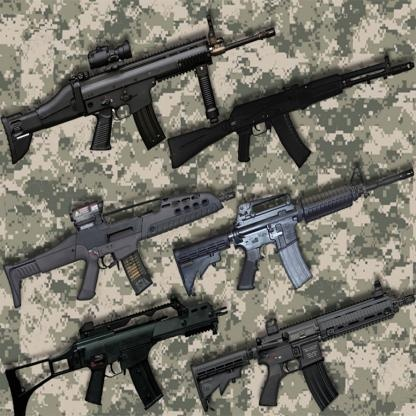

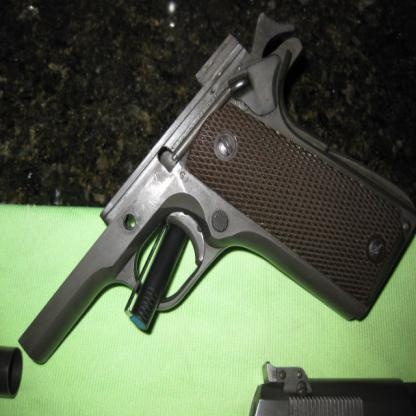

In [31]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")